#**Independent Component Analysis**


Imagine you are a spy at an embassy coctail party and various VIP and diplomats are at this party. Now you have 2 major groups at the party. The first is the Americans and the second is the Russians.  Now if you were trying to record these conversations with 1 microphone you would get extremely distorted sound quality.Now you may think I can just put 2 microphones in the room. Yes this is true you could do this, but you will still get levels of noise from each conversation. You will also not know where to put the microphones exactly. You can see in Fig 1 below that each source is mixed together and the outputs in $s_1$ and $ S_2$ and mixed by some matrix A. So this is where Independent Component Analysis (ICA) comes in. It helps filter conflicting sources into their original source.  

![image.png](https://www.computing.dcu.ie/~amccarren/mcm_images/coctail_party.png)
Fig 1


ICA (also known as Blind Signal Seperation) allows us to identify & separate a mixtures of sources with little prior information. There are many applications and these include the following:

* Audio Processing
* Medical data
* Finance
* Array processing (beamforming)
* Coding

and most applications where Factor Analysis and PCA is currently used.

While PCA seeks directions that represents data best, ICA seeks such directions that are most independent from each other.

In this step We are going to rely on notes written by  [Klein Carsten](https://github.com/akcarsten/Independent_Component_Analysis). I however use Sklearn FastICA instead of Kleins method, as Kliens version is quite long. But, I would suggest you implement and compare the results.


As we saw from fig 1 ICA assumes we generate the observed data from an underlying unknown independent processes $x$ with mixing signals $A$.

>>$x=As$

Now lets get started with the coding for a simple process. We will need the following libraries.


In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline




**Create toy signals**
We will start by creating some independent signals that will be mixed by matrix A. The independent sources signals are (1) a sine wave, (2) a saw tooth signal and (3) a random noise vector. After calculating their dot product with A we get three linear combinations of these source signals.

In [2]:
# Set a seed for the random number generator for reproducibility
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

# Source matrix
S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T



# Mixing matrix
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])


# Mixed signal matrix
X = S.dot(A).T

Now we will just plot all the original signals and their mixed versions.

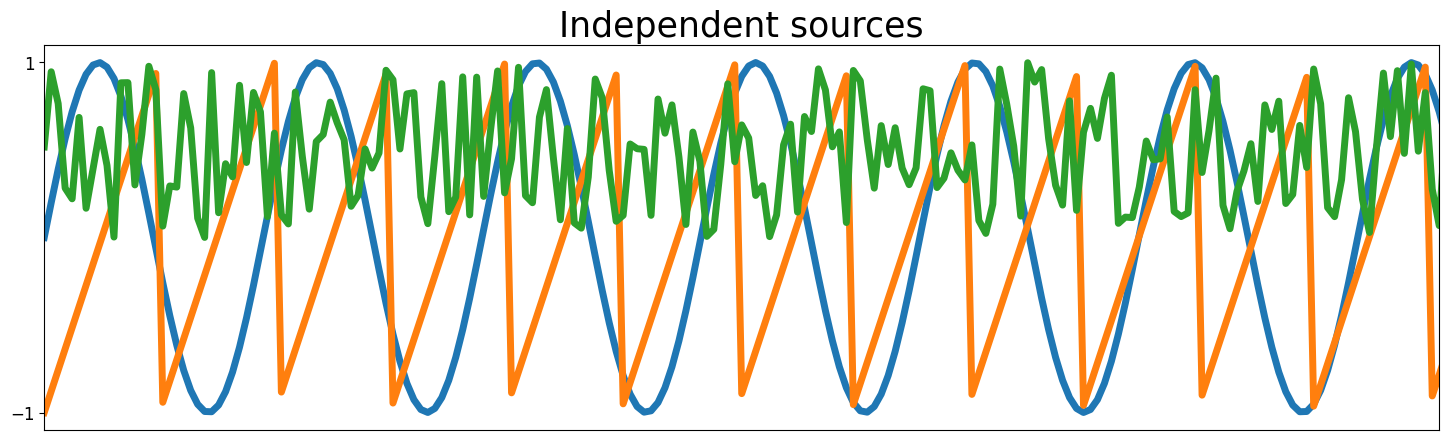

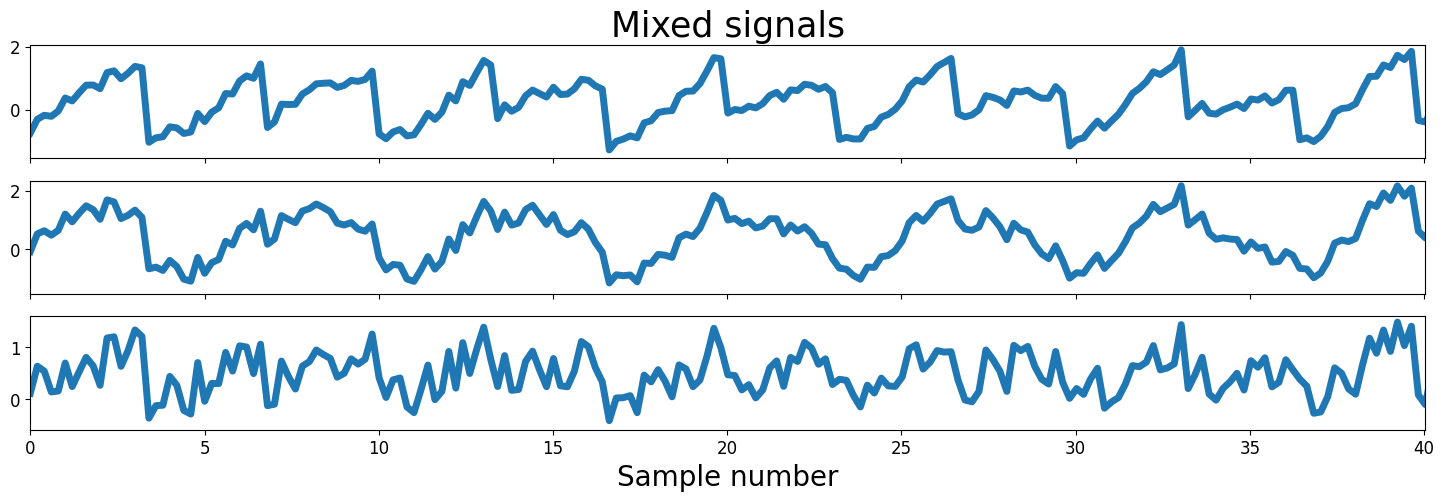

In [3]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

The code above generates 3 plots from the orginal 3 signals. Each is mixed with the other 2 signals with a mixing matrix A.

**Retrieving the components**
The above equations implies that if we invert A and multiply it with the observed signals x we will retrieve our sources:

>> $W=A^{-1}$

>> $s=xW$

This means that what our ICA algorithm needs to estimate is W. So the challenge for ICA is to find the matrix W which will always be unknown.

**ICA Assumptions**

The following assumptions exist when applying ICA:
* The mixed signals are linear combinations of any number of source signals
* The source signals are independent of each other. In otherwords there isn't and individual who is taking part in both conversations.
* The independent components are non-Gausian.  [Klein](https://github.com/akcarsten/Independent_Component_Analysis) gives the following explaination :

"The joint density distribution of two independent non-Gaussian signals will be uniform on a square. Mixing these two signals with an orthogonal matrix will result in two signals that are now not independent anymore and have a uniform distribution on a parallelogram. Which means that if we are at the minimum or maximum value of one of our mixed signals we know the value of the other signal. Therefore they are not independent anymore. Doing the same with two Gaussian signals will result in something else. The joint distribution of the source signals is completely symmetric and so is the joint distribution of the mixed signals. Therefore it does not contain any information about the mixing matrix, the inverse of which we want to calculate. It follows that in this case the ICA algorithm will fail".

Figure 2 tries to explain this in so far as if you mix 2 guasian sorces you will not have any directions to work from.

![image.png](https://www.computing.dcu.ie/~amccarren/mcm_images/ICA_gausianVsnongausian.png)

I prefer to use the logic that if you add 2 gausian distributions together then you will get another guasian distribution but the new signal as no information as to the orginal paramters of the source signal.

So you can go to Kleins repository to read further on this if you want. The key to solving the this problem is maximizing the non-guassianity of $s=xW$. There are numerous  [measures of Non-Guassianity](http://fourier.eng.hmc.edu/e161/lectures/ica/node4.html) but for the purposes of this step we are going to use the 'logcosh' which is the default in python. Next we will go through some of the preprocessing requirements for an ICA.

**Preprocessing**

In ICA we generally use 2 preprocessing steps as it is not a good idea to insert your data directly into Pythons fastIca.


* Centering is the first preprocessing step and is basically the same that we used for PCA, where we take away the mean for each observation:
> $\hat{x_i}=x_i-\bar{x}$

**Whitening**

The second pre-processing step that we need to do is to whiten our signals X. The goal here is to linearly transform X so that potential correlations between the signals are removed and their variances equal unity. As a result the covariance matrix of the whitened signals will be equal to the identity matrix. Now in FastICA we will use the default parameters. I have found it quite difficult to change my contrast function to a user specified one using scikit learns library. I expect this is why Klein developed his own version of FastICA.


So we will now implement an ICA with the data outlined above  using scikit learns version of FastICA. I would also like you to implement Kleins approach and compare your results.



In [5]:
import numpy as np
# Set a seed for the random number generator for reproducibility
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

# Source matrix
S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T
S /= S.std(axis=0)
# Plot sources & signals
meanPoint = S.mean(axis = 0)
S=S-meanPoint
#S /= S.std(axis=0)



#print(S)
# Mixing matrix
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signal matrix
X = np.dot(S, A.T)
print(X.shape)


from sklearn.decomposition import FastICA
ica = FastICA(n_components=3, fun='logcosh', whiten='unit-variance', random_state=23)
#,fun='exp','logcosh'
S_ = ica.fit_transform(X)  # Reconstruct signals
print(S_.shape)
A_ = ica.mixing_  # Get estimated mixing matrix

print(A_)

(1000, 3)
(1000, 3)
[[ 0.16357122  0.49531726 -1.01139758]
 [ 0.38626647  0.99401047 -0.52396464]
 [ 0.97064553  0.48612906 -0.84620431]]


You will see from the code above that we have used the "logcosh" contrast function. This function is specified to minimise the guassinity of the sources.
We then plot the results and compare them to the original sources.

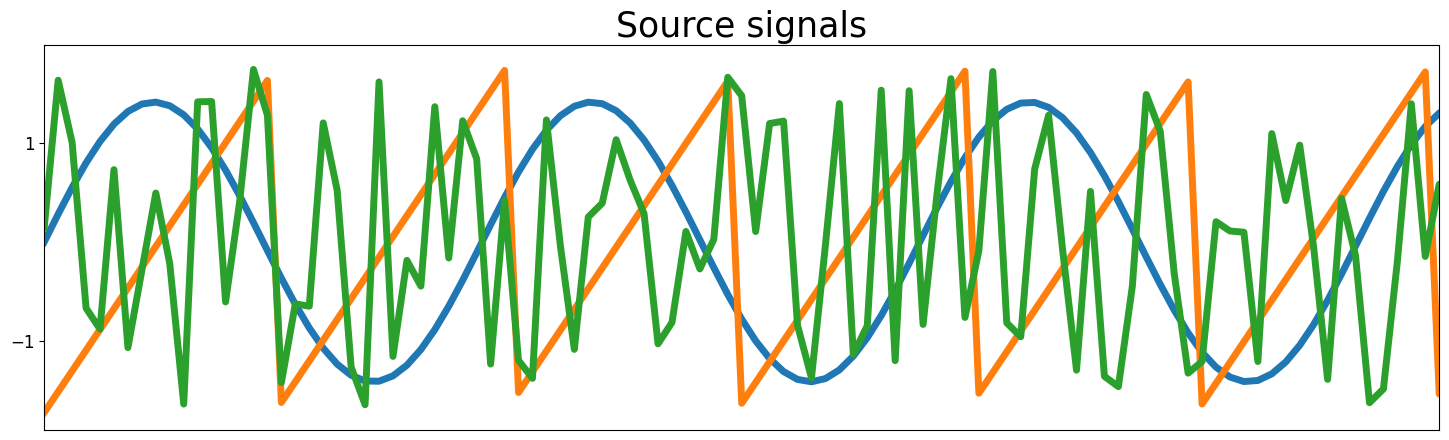

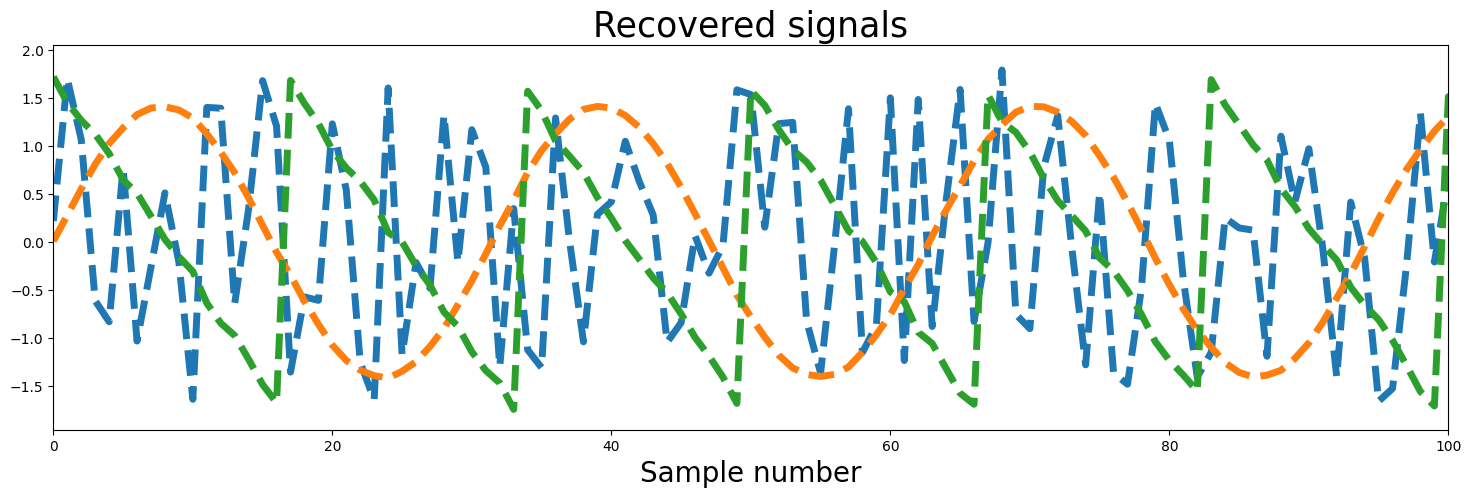

In [6]:
# Plot sources & signals


fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)


fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S_, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

The output shows us that we have found quite similar  sources to the original ones. One thing to note is FASTica from scikit learn does not recreate the sources in their orginal scale, however, Klein rescales the results. When I implemented Kleins approach I got better results. I suspect this is caused by the contrast function that I used above.


Can you now implement Kleins approach and compare the results.